# Supervised survival predictor

## Load libraries

In [1]:
# Base
import pandas as pd
import numpy as np
import random
# Pre-processing the data
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
# Baseline comparison
from sklearn.dummy import DummyClassifier
# ML models
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
# Evaluation models
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, average_precision_score
# Comparison models
import shap
# Plotting
import matplotlib.pyplot as plt
# utils 
import joblib
import pickle

## Read input data

In [2]:
df_train =pd.read_csv('C:/Users/mtello/Documents/GitHub/MetastaticMelanomaSC/Data/train_ft_sd_topvar.tsv', sep='\t')
df_test =pd.read_csv('C:/Users/mtello/Documents/GitHub/MetastaticMelanomaSC/Data/test_ft_sd_topvar.tsv', sep='\t')
df_validation = pd.read_csv('C:/Users/mtello/Documents/GitHub/MetastaticMelanomaSC/Data/bulk_validation_sd_encoded.tsv', sep='\t')

In [3]:
df_train.head()

,tumor_id,Resistant,ENSG00000124608,ENSG00000069431,ENSG00000176244,ENSG00000160710,ENSG00000120907,ENSG00000116771,ENSG00000156709,ENSG00000166452,...,ENSG00000160908,ENSG00000173258,ENSG00000198740,ENSG00000198429,ENSG00000120963,ENSG00000178665,ENSG00000168612,ENSG00000132155,ENSG00000187098,ENSG00000213281
0,58,0,-0.239850,0.348660,0.140166,-0.630897,0.123888,0.467946,0.263744,0.064099,...,0.514542,-0.182405,-0.063871,0.196094,0.426032,-0.498049,1.380055,1.823265,0.641911,-0.437900
1,58,0,0.524385,0.678833,0.716160,-0.674491,1.212713,-0.330485,1.773853,-0.133207,...,0.689396,-0.214684,0.107916,-0.674491,0.319168,-0.562136,-0.090620,-0.674491,0.613199,0.990457
2,58,0,0.253800,0.508157,0.620378,-0.647734,0.639000,-0.348470,-0.039796,0.561428,...,0.930745,-0.441993,5.771662,0.618982,0.687760,-0.450233,0.951622,-0.674491,0.281736,0.585083
3,58,0,-0.828007,-0.576342,-1.580702,-0.086564,1.386536,-0.167758,0.686338,-0.606218,...,-1.004077,-0.186294,3.986752,0.002034,-0.449542,-0.325045,-0.674491,1.342497,-0.485694,-0.365623
4,58,0,0.054213,0.964209,0.400561,-0.674491,0.388831,0.721457,-0.208313,-0.216688,...,0.400095,-0.388990,-0.269984,-0.062271,0.454796,4.373151,0.286701,-0.674491,0.329908,-0.616018


## Encode target variable

In [4]:
drop_features=["tumor_id", "Resistant"]

In [5]:
le = LabelEncoder()

X_train_enc = df_train.drop(columns = drop_features, inplace = False)
y_train = le.fit_transform(df_train["Resistant"])
X_test_enc = df_test.drop(columns = drop_features, inplace = False)
y_test = le.fit_transform(df_test["Resistant"])

X_train_enc.head()

,ENSG00000124608,ENSG00000069431,ENSG00000176244,ENSG00000160710,ENSG00000120907,ENSG00000116771,ENSG00000156709,ENSG00000166452,ENSG00000149925,ENSG00000065413,...,ENSG00000160908,ENSG00000173258,ENSG00000198740,ENSG00000198429,ENSG00000120963,ENSG00000178665,ENSG00000168612,ENSG00000132155,ENSG00000187098,ENSG00000213281
0,-0.239850,0.348660,0.140166,-0.630897,0.123888,0.467946,0.263744,0.064099,0.807533,-0.548355,...,0.514542,-0.182405,-0.063871,0.196094,0.426032,-0.498049,1.380055,1.823265,0.641911,-0.437900
1,0.524385,0.678833,0.716160,-0.674491,1.212713,-0.330485,1.773853,-0.133207,0.149829,0.903302,...,0.689396,-0.214684,0.107916,-0.674491,0.319168,-0.562136,-0.090620,-0.674491,0.613199,0.990457
2,0.253800,0.508157,0.620378,-0.647734,0.639000,-0.348470,-0.039796,0.561428,-3.978601,0.016079,...,0.930745,-0.441993,5.771662,0.618982,0.687760,-0.450233,0.951622,-0.674491,0.281736,0.585083
3,-0.828007,-0.576342,-1.580702,-0.086564,1.386536,-0.167758,0.686338,-0.606218,0.553212,0.810471,...,-1.004077,-0.186294,3.986752,0.002034,-0.449542,-0.325045,-0.674491,1.342497,-0.485694,-0.365623
4,0.054213,0.964209,0.400561,-0.674491,0.388831,0.721457,-0.208313,-0.216688,-3.978601,-0.674491,...,0.400095,-0.388990,-0.269984,-0.062271,0.454796,4.373151,0.286701,-0.674491,0.329908,-0.616018


## Train with default hyper-params

### Dummy

In [6]:
DummyBaseline=DummyClassifier()
DummyBaseline.fit(X_train_enc, y_train)
DummyBaseline.score(X_train_enc, y_train)

0.8780418788907753

### XGBoost

In [7]:
XGB_pipe = XGBClassifier(objective='binary:logistic', 
                         eval_metric='logloss', 
                         random_state=123)
XGB_pipe.fit(X_train_enc, y_train)
XGB_pipe.score(X_train_enc, y_train)

1.0

In [8]:
classifiers = {
    'DummyClassifier': DummyBaseline,
    'XGBoost': XGB_pipe
}

# Define the scoring methods
scoring_methods = {
    'F1 Score': make_scorer(f1_score, average='binary'),  
    'AUROC': make_scorer(roc_auc_score, needs_proba=True),
    'AUPR': make_scorer(average_precision_score, needs_proba=True)
}

# Specify the number of folds
n_splits = 5

# Define StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)

mean_results_dict = dict()
std_results_dict = dict()

for name, classifier in classifiers.items():
    print(name)
    results = cross_validate(classifier, X_train_enc, y_train, scoring=scoring_methods, return_train_score=True, cv=stratified_kfold)
    mean_results_dict[name] = {key: value.mean() for key, value in results.items()}
    std_results_dict[name] = {key: value.std() for key, value in results.items()}

results = pd.DataFrame(mean_results_dict).T
results

DummyClassifier
XGBoost


,fit_time,score_time,test_F1 Score,train_F1 Score,test_AUROC,train_AUROC,test_AUPR,train_AUPR
DummyClassifier,0.007839,0.003646,0.000000,0.0,0.500000,0.5,0.121958,0.121958
XGBoost,2.389064,0.129957,0.891259,1.0,0.990186,1.0,0.967158,1.000000


## Hyper parameter tunning

In [9]:
x = 10.0 ** np.arange(-2, 0, 0.1)
y = 10.0 ** np.arange(-2, 2, 0.5)
param_choices = {
    "n_estimators": np.arange(100, 150 , 10),
    "max_depth": np.arange(4, 15, 1),
    "learning_rate": x,
    "reg_alpha": y
}

scoring_metric = 'average_precision'  
# Create a RandomizedSearchCV object with stratified cross-validation
random_search = RandomizedSearchCV(XGB_pipe, param_choices, n_iter=50, n_jobs= 1,
                                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123),  
                                   scoring=scoring_metric, random_state=123)
# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train_enc, y_train)
# Get the parameter choices as a list
param_names = ['param_' + param for param in list(param_choices.keys())] 
# Extract relevant columns from cv_results_
result_df = pd.DataFrame(random_search.cv_results_)[['mean_test_score'] + param_names + ['mean_fit_time', 'rank_test_score']]
# Set 'rank_test_score' as the index and sort by it
result_df = result_df.set_index("rank_test_score").sort_index()
# Display the DataFrame
result_df.head()

,mean_test_score,param_n_estimators,param_max_depth,param_learning_rate,param_reg_alpha,mean_fit_time
rank_test_score,,,,,,
1,0.967839,120,7,0.199526,0.031623,3.306094
2,0.967308,120,6,0.125893,0.316228,3.498442
3,0.967092,140,13,0.199526,0.031623,4.088659
4,0.966901,110,5,0.316228,0.01,2.155110
5,0.966613,130,6,0.398107,0.316228,2.375886


In [10]:
# Save the DataFrame with CV results to a CSV file
cv_results_file = 'cv_results_sd.tsv'
result_df.to_csv(cv_results_file, sep = '\t', index=False)

# Save the best model trained during the randomized search to a pickle file
best_model_file = 'best_model_sd.pkl'
joblib.dump(random_search.best_estimator_, best_model_file)

# Optionally, you can also save the RandomizedSearchCV object itself
random_search_file = 'random_search_sd.pkl'
joblib.dump(random_search, random_search_file)

['random_search_sd.pkl']

## Evaluation in the test split

In [11]:
best_model = DummyBaseline
# Define the scoring metrics
scoring_methods = {
    'F1 Score': make_scorer(f1_score, average='binary'),
    'AUROC': make_scorer(roc_auc_score, needs_proba=True),
    'AUPR': make_scorer(average_precision_score, needs_proba=True)
}
# Use cross_validate to evaluate the model
results = cross_validate(best_model, X_test_enc, y_test, scoring=scoring_methods, cv=5)
for metric, scores in results.items():
# Display the results
    print(f"{metric}: {scores.mean()} (±{scores.std()})")

fit_time: 0.0 (±0.0)
score_time: 0.005924844741821289 (±0.005963630345909121)
test_F1 Score: 0.0 (±0.0)
test_AUROC: 0.5 (±0.0)
test_AUPR: 0.1197107421322668 (±0.002127029294394692)


In [12]:
best_model = random_search.best_estimator_
# Define the scoring metrics
scoring_methods = {
    'F1 Score': make_scorer(f1_score, average='binary'),
    'AUROC': make_scorer(roc_auc_score, needs_proba=True),
    'AUPR': make_scorer(average_precision_score, needs_proba=True)
}
# Use cross_validate to evaluate the model
results = cross_validate(best_model, X_test_enc, y_test, scoring=scoring_methods, cv=5)
for metric, scores in results.items():
# Display the results
    print(f"{metric}: {scores.mean()} (±{scores.std()})")


fit_time: 1.1264327049255372 (±0.05118477442036731)
score_time: 0.1273531436920166 (±0.009398831791751107)
test_F1 Score: 0.7412435059493883 (±0.2285065753096867)
test_AUROC: 0.9801129910653721 (±0.025639484451475857)
test_AUPR: 0.9111133681379464 (±0.1051385797270946)


## Prediction on bulk data

In [13]:
X_val_enc = df_validation.drop(columns = drop_features, inplace = False)
y_val = le.fit_transform(df_validation["Resistant"])
X_val_enc.head()

,ENSG00000124608,ENSG00000069431,ENSG00000176244,ENSG00000160710,ENSG00000120907,ENSG00000116771,ENSG00000156709,ENSG00000166452,ENSG00000149925,ENSG00000065413,...,ENSG00000160908,ENSG00000173258,ENSG00000198740,ENSG00000198429,ENSG00000120963,ENSG00000178665,ENSG00000168612,ENSG00000132155,ENSG00000187098,ENSG00000213281
0,-0.913024,-0.606376,-1.605374,0.478586,-1.634630,-1.337510,-0.454854,-0.642133,0.983472,-0.918055,...,-0.229908,-1.615516,-0.703838,-0.994089,-0.285949,-1.393723,-0.849977,0.221162,-0.520833,0.081549
1,-0.405359,-1.406733,-1.653303,0.461159,-1.670938,-1.409837,-0.416582,-0.699374,1.286189,-1.095872,...,0.000173,-1.636486,-0.724991,-1.403541,-0.112153,-1.169595,-0.626073,0.449686,-0.528469,-0.013436
2,-0.094751,-1.155653,-1.465073,0.545077,-1.514650,-1.589776,-0.144922,-0.306060,1.359382,-1.273772,...,-0.310254,-1.423942,-0.146956,-1.190960,0.004378,-1.431988,-0.565204,0.252659,0.548897,-0.029854
3,-0.624484,-1.091972,-1.342257,0.689405,-1.699549,-1.332168,-0.008836,-0.544465,1.399229,-1.317583,...,-0.445703,-1.717598,-0.396428,-1.038096,-0.119071,-1.502864,-0.521075,0.215496,-0.028977,0.134385
4,-0.295126,-1.580141,-1.573545,0.673559,-1.666851,-1.276423,0.002677,-0.693990,1.784623,-1.129171,...,-0.283051,-1.654453,-0.956573,-1.359445,-0.300491,-1.156154,-0.775433,0.066857,0.985695,0.478729


In [14]:
best_model.predict(X_val_enc)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
y_val

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1], dtype=int64)

In [19]:
np.set_printoptions(suppress=True)

In [23]:
np.round(best_model.predict_proba(X_val_enc), 4)

array([[0.9856, 0.0144],
       [0.993 , 0.007 ],
       [0.9996, 0.0004],
       [0.9997, 0.0003],
       [0.9183, 0.0817],
       [0.9663, 0.0337],
       [0.998 , 0.002 ],
       [0.9768, 0.0232],
       [0.983 , 0.017 ],
       [0.9855, 0.0145]], dtype=float32)

## SHAP evaluation

In [24]:
explainer = shap.TreeExplainer(best_model,shap.sample(X_train_enc, 2000), model_output="probability")

[22:25:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [25]:
sc_dt = pd.concat([df_train, df_test])
sc_dt = sc_dt.reset_index(drop=True)
sc_dt.head()

,tumor_id,Resistant,ENSG00000124608,ENSG00000069431,ENSG00000176244,ENSG00000160710,ENSG00000120907,ENSG00000116771,ENSG00000156709,ENSG00000166452,...,ENSG00000160908,ENSG00000173258,ENSG00000198740,ENSG00000198429,ENSG00000120963,ENSG00000178665,ENSG00000168612,ENSG00000132155,ENSG00000187098,ENSG00000213281
0,58,0,-0.239850,0.348660,0.140166,-0.630897,0.123888,0.467946,0.263744,0.064099,...,0.514542,-0.182405,-0.063871,0.196094,0.426032,-0.498049,1.380055,1.823265,0.641911,-0.437900
1,58,0,0.524385,0.678833,0.716160,-0.674491,1.212713,-0.330485,1.773853,-0.133207,...,0.689396,-0.214684,0.107916,-0.674491,0.319168,-0.562136,-0.090620,-0.674491,0.613199,0.990457
2,58,0,0.253800,0.508157,0.620378,-0.647734,0.639000,-0.348470,-0.039796,0.561428,...,0.930745,-0.441993,5.771662,0.618982,0.687760,-0.450233,0.951622,-0.674491,0.281736,0.585083
3,58,0,-0.828007,-0.576342,-1.580702,-0.086564,1.386536,-0.167758,0.686338,-0.606218,...,-1.004077,-0.186294,3.986752,0.002034,-0.449542,-0.325045,-0.674491,1.342497,-0.485694,-0.365623
4,58,0,0.054213,0.964209,0.400561,-0.674491,0.388831,0.721457,-0.208313,-0.216688,...,0.400095,-0.388990,-0.269984,-0.062271,0.454796,4.373151,0.286701,-0.674491,0.329908,-0.616018


In [26]:
df_train_reset = df_train.reset_index(drop=True)
df_test_reset = df_test.reset_index(drop=True)

sc_dt = pd.concat([df_train_reset, df_test_reset])
sc_dt = sc_dt.reset_index(drop=True)
sc_dt_enc = sc_dt.drop(columns = drop_features, inplace = False)

shap_sc = explainer.shap_values(sc_dt_enc)
shap_sc = pd.DataFrame(shap_sc, columns=X_train_enc.columns)
# Add columns from df_train to shap_df
shap_sc = explainer.shap_values(sc_dt_enc)
shap_sc = pd.DataFrame(shap_sc, columns=X_train_enc.columns)
shap_sc = pd.concat([sc_dt[["tumor_id", "Resistant"]], shap_sc], axis= 1)
shap_file = 'shap_values_sc.tsv'
shap_sc.to_csv(shap_file, sep = '\t', index=False)

 99%|===================| 4593/4645 [00:11<00:00]       

In [27]:
shap_validation = explainer.shap_values(X_val_enc)
shap_validation = pd.DataFrame(shap_validation, columns=X_val_enc.columns)
# Add columns from df_train to shap_df
columns_to_add = ["tumor_id", "Resistant"]
for col in columns_to_add:
    shap_validation[col] = df_validation[col]
shap_file = 'shap_values_validation.tsv'
shap_validation.to_csv(shap_file, sep = '\t', index=False)

In [28]:
shap_validation

,ENSG00000124608,ENSG00000069431,ENSG00000176244,ENSG00000160710,ENSG00000120907,ENSG00000116771,ENSG00000156709,ENSG00000166452,ENSG00000149925,ENSG00000065413,...,ENSG00000198740,ENSG00000198429,ENSG00000120963,ENSG00000178665,ENSG00000168612,ENSG00000132155,ENSG00000187098,ENSG00000213281,tumor_id,Resistant
0,0.0,-0.001058,-4.721734e-06,-0.000317,0.0,0.0,-4.270904e-06,-0.000315,0.000035,0.0,...,0.0,0.000042,0.000422,0.000072,-0.000394,0.000006,1.917610e-05,0.0,11,0
1,0.0,-0.001007,-3.057538e-06,-0.000270,0.0,0.0,-2.474625e-06,-0.000273,0.000042,0.0,...,0.0,0.000019,0.000022,0.000194,-0.000346,0.000005,1.352478e-05,0.0,12,1
2,0.0,-0.000902,-7.992832e-07,-0.000181,0.0,0.0,-3.627886e-07,-0.000192,0.000018,0.0,...,0.0,0.000026,0.000033,0.000114,-0.000244,0.000008,-7.962244e-07,0.0,21,0
3,0.0,-0.000906,-7.688898e-07,-0.000179,0.0,0.0,-3.408675e-07,-0.000190,0.000018,0.0,...,0.0,0.000025,0.000033,0.000113,-0.000241,0.000008,4.816515e-06,0.0,22,1
4,0.0,-0.001288,-2.333139e-05,-0.000609,0.0,0.0,-1.151207e-05,-0.000085,0.000117,0.0,...,0.0,0.000073,0.000869,0.000209,-0.000626,0.000051,-1.762005e-05,0.0,31,0
5,0.0,-0.001179,-1.246457e-05,-0.000405,0.0,0.0,-5.600933e-06,-0.000042,0.000065,0.0,...,0.0,0.000053,0.000575,0.000117,-0.000480,0.000038,2.427663e-05,0.0,32,1
6,0.0,-0.001068,-1.585870e-06,-0.000220,0.0,0.0,-1.020505e-06,-0.000227,0.000021,0.0,...,0.0,0.000030,0.000271,0.000034,-0.000291,0.000009,-1.811079e-06,0.0,41,0
7,0.0,-0.001051,-6.456223e-06,-0.000361,0.0,0.0,-6.235056e-06,-0.000355,0.000042,0.0,...,0.0,0.000048,0.000476,0.000299,-0.000438,0.000013,2.485564e-05,0.0,42,0
8,0.0,-0.000997,-5.259849e-06,-0.000331,0.0,0.0,-4.872228e-06,-0.000328,0.000033,0.0,...,0.0,0.000044,0.000446,0.000263,-0.000408,0.000012,-7.026234e-06,0.0,51,0
9,0.0,-0.000992,-7.114437e-06,-0.000341,0.0,0.0,-4.294463e-06,-0.000315,0.000035,0.0,...,0.0,0.000042,0.000423,0.000073,-0.000395,0.000012,1.924664e-05,0.0,52,1


In [29]:
shap_values_sc = explainer(sc_dt_enc)
shap_values_validation = explainer(X_val_enc)


 95%|=================== | 4425/4645 [00:11<00:00]       

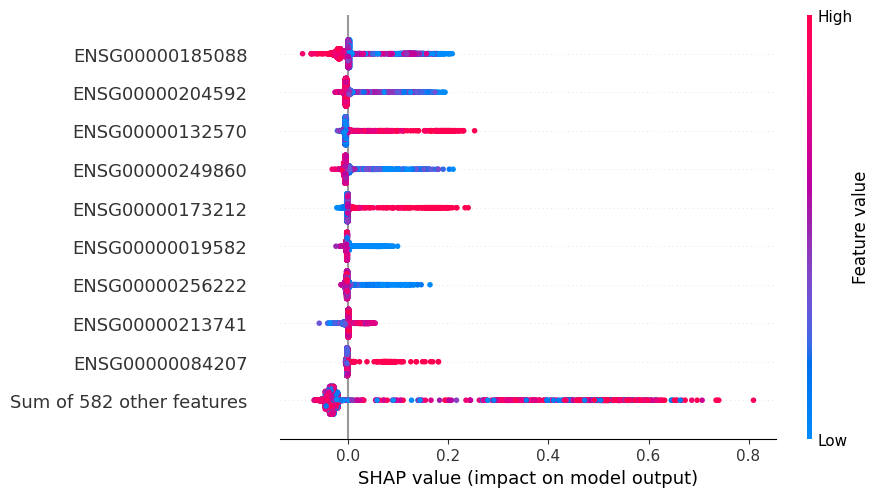

In [30]:
shap.plots.beeswarm(shap_values_sc)


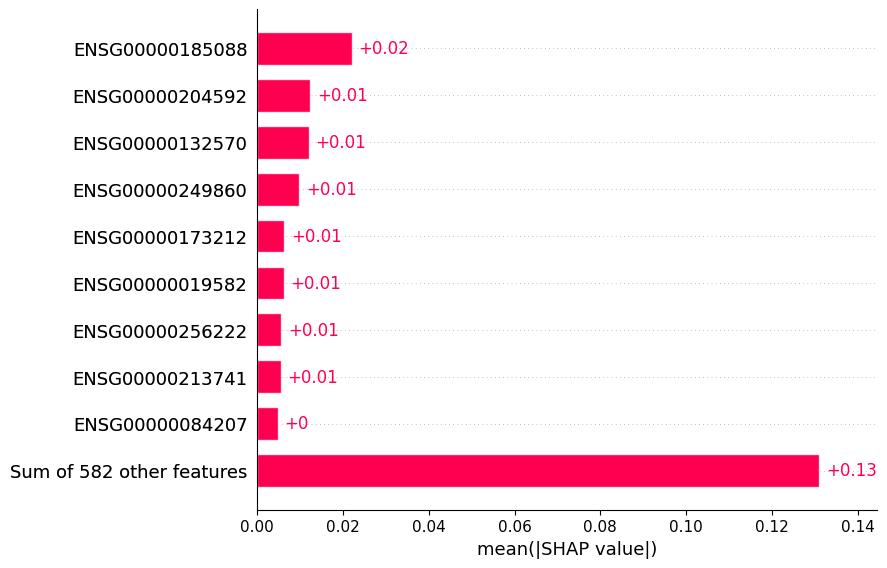

In [37]:
shap.plots.bar(shap_values_sc)

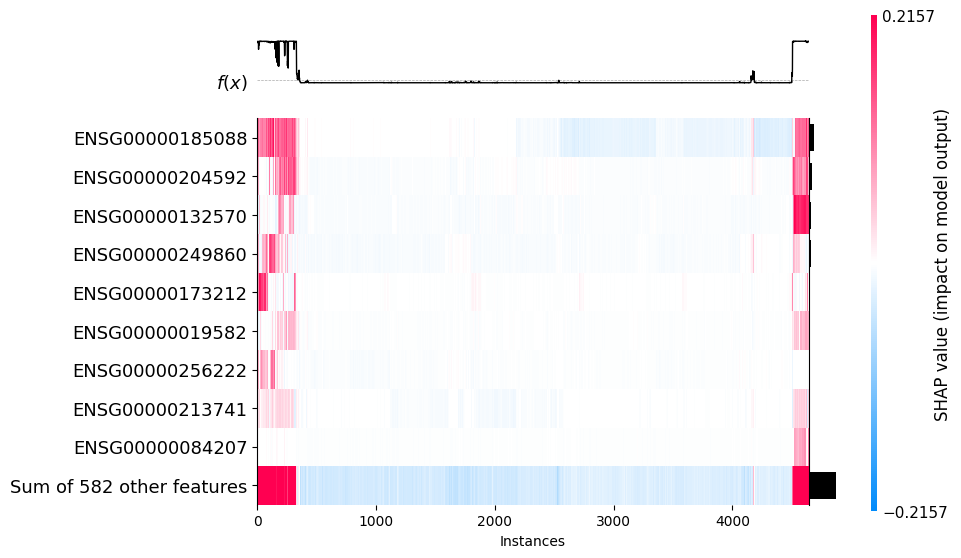

In [38]:
shap.plots.heatmap(shap_values_sc)